In [ ]:
!pip install imutils

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import random
from tensorflow.keras import layers

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
original_data_dir = "/content/drive/MyDrive/OS Collected Data"
split_data_dir = "/content/drive/MyDrive/OS Collected Data/sample"

# Define categories (folders)
categories = ['Normal', 'Osteopenia', 'Osteoporosis']

# Create Training and Testing directories
for category in categories:
    os.makedirs(os.path.join(split_data_dir, "Training", category), exist_ok=True)
    os.makedirs(os.path.join(split_data_dir, "Testing", category), exist_ok=True)

# Train-Test Split Ratio
split_ratio = 0.8  # 80% training, 20% testing

# Process each category
for category in categories:
    category_path = os.path.join(original_data_dir, category)
    images = os.listdir(category_path)

    # Shuffle images randomly
    random.shuffle(images)

    # Split dataset
    train_size = int(len(images) * split_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Move files to respective folders
    for img in train_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(split_data_dir, "Training", category, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(split_data_dir, "Testing", category, img)
        shutil.copy(src, dst)

print("Dataset successfully split and folders created! ✅")

Dataset successfully split and folders created! ✅


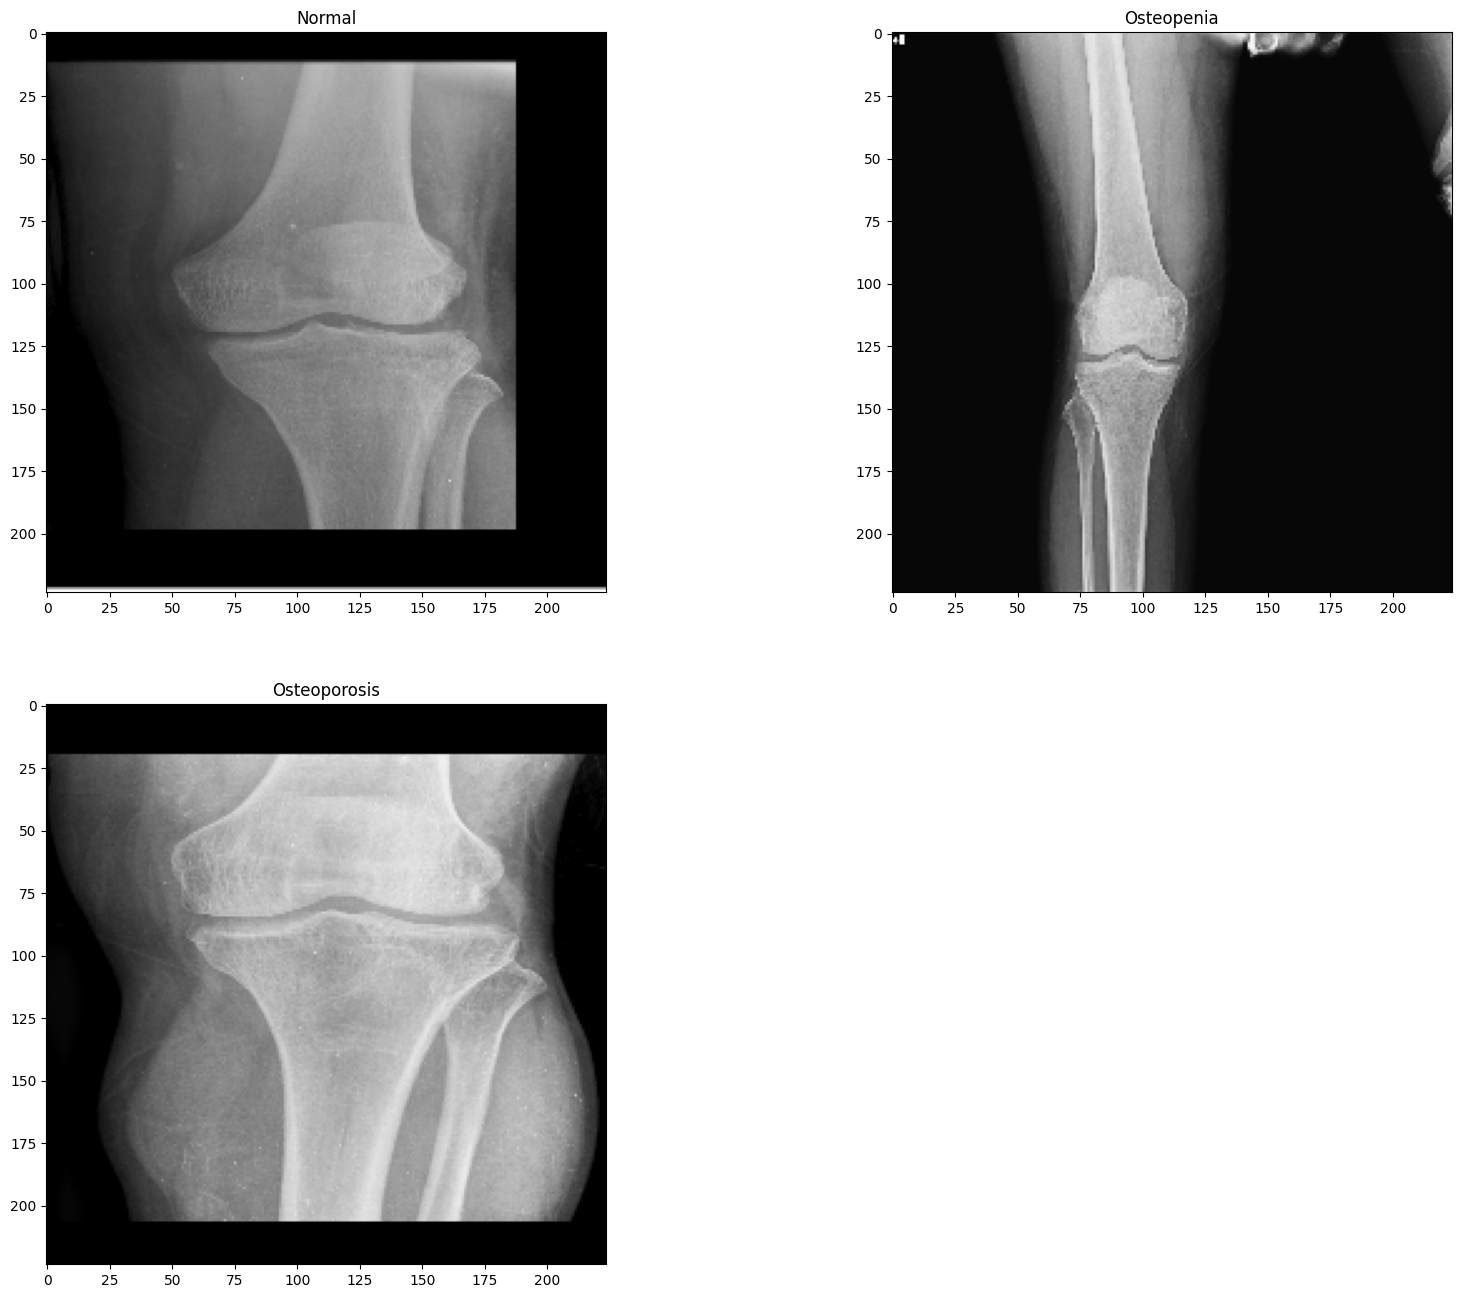

In [ ]:
# Sample Image Paths
data_dir = '/content/drive/MyDrive/OS Collected Data/sample/Training'
categories = ['Normal', 'Osteopenia', 'Osteoporosis']
plt.figure(figsize=(20, 16))

images_path = ['/Normal/Normal 1.png', '/Osteopenia/Osteopenia 1.jpg', '/Osteoporosis/Osteoporosis 10.png']

for i in range(len(images_path)):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])

    if img is None:
        print(f"Error loading image: {data_dir + images_path[i]}")
        continue  # Skip this iteration if the image is not found

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

plt.show()

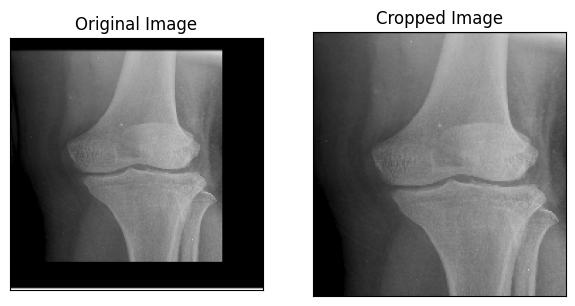

In [ ]:
# Image Cropping Function
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

# Sample image and apply cropping
img = cv2.imread('/content/drive/MyDrive/OS Collected Data/sample/Training/Normal/Normal 1.png')
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cropped_img = crop_img(img)

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([]), plt.yticks([]), plt.title('Original Image')
plt.subplot(142)
plt.imshow(cropped_img)
plt.xticks([]), plt.yticks([]), plt.title('Cropped Image')
plt.show()

100%|██████████| 159/159 [00:04<00:00, 34.44it/s]


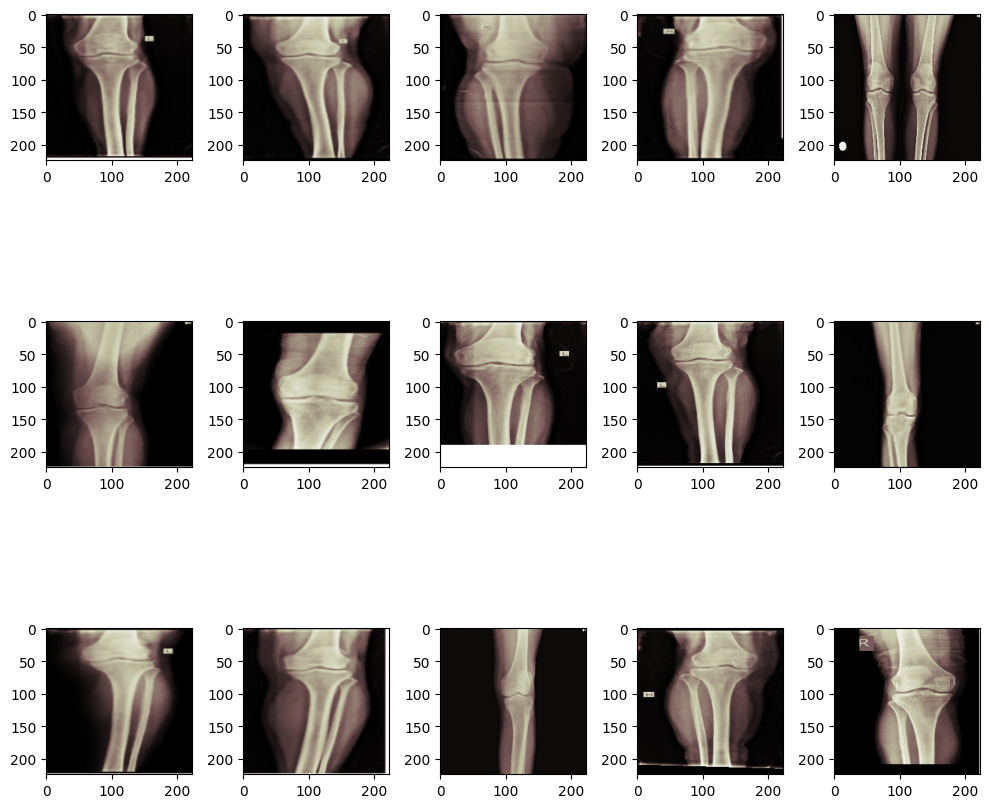

In [ ]:
# Prepare Data
labels = ['Normal', 'Osteopenia', 'Osteoporosis']

x_train = []
y_train  = []
x_test = []
y_test = []

image_size = 224

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/OS Collected Data/sample/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/MyDrive/OS Collected Data/sample/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Visualize images
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

# Train-Validation Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2)

datagen.fit(x_train)

In [ ]:
# Custom CNN Model

IMG_SIZE = (224, 224, 3)  # Input image size

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SIZE),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 3D output to 1D
    Flatten(),

    # Fully Connected Layer 1
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer (softmax for multi-class classification)
    Dense(3, activation='softmax')  # 3 classes for classification
])

# Compile the model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,859,139 (98.64 MB)

 Trainable params: 25,858,435 (98.64 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=1e-10),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(x_val, y_val), epochs=15, callbacks=callbacks)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.4648 - loss: 4.2007
Epoch 1: val_loss improved from inf to 1.68794, saving model to .mdl_wts.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4653 - loss: 4.1440 - val_accuracy: 0.4103 - val_loss: 1.6879 - learning_rate: 1.0000e-04
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.4938 - loss: 1.1906
Epoch 2: val_loss did not improve from 1.68794
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 721ms/step - accuracy: 0.4939 - loss: 1.1848 - val_accuracy: 0.3974 - val_loss: 4.5752 - learning_rate: 1.0000e-04
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.5275 - loss: 0.9205
Epoch 3: val_loss did not improve from 1.68794

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 746ms/step - accuracy: 0.5273 - loss: 0.9214 - val_accuracy: 0.3974 - val_loss: 7.0415 - learning_rate: 1.0000e-04
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - ac

In [ ]:
# Classification Report
predicted_classes = np.argmax(model.predict(x_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
              precision    recall  f1-score   support

      Normal       0.80      0.03      0.05       156
  Osteopenia       0.00      0.00      0.00        75
Osteoporosis       0.41      0.99      0.58       159

    accuracy                           0.42       390
   macro avg       0.40      0.34      0.21       390
weighted avg       0.49      0.42      0.26       390



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Confusion Matrix
pred_Y = model.predict(x_test, batch_size=8, verbose=True)
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_Y, axis=1))

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


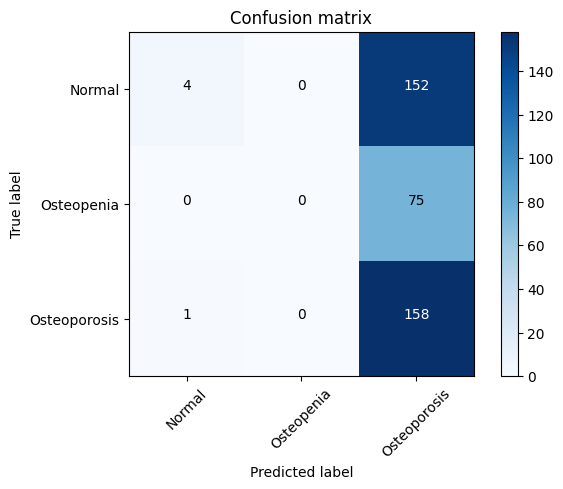

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot Confusion Matrix
plot_confusion_matrix(confusion_mtx, classes=labels)

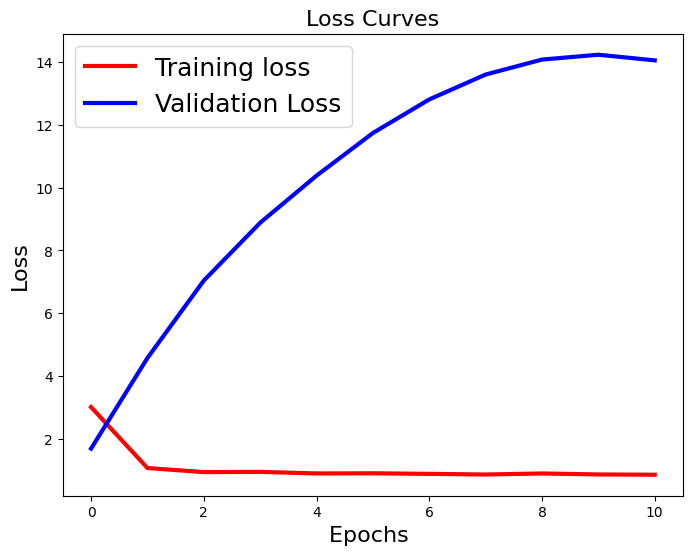

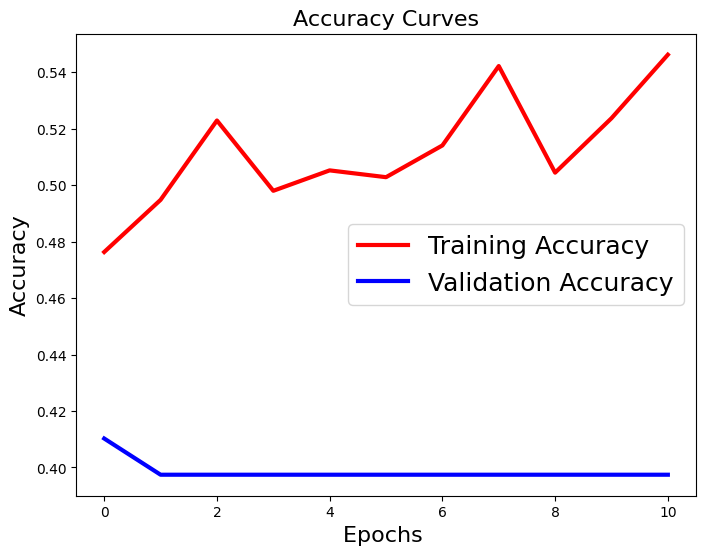

In [ ]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [ ]:
# Evaluation on Test Set
loss, acc = model.evaluate(x_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1760 - loss: 1.7903


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


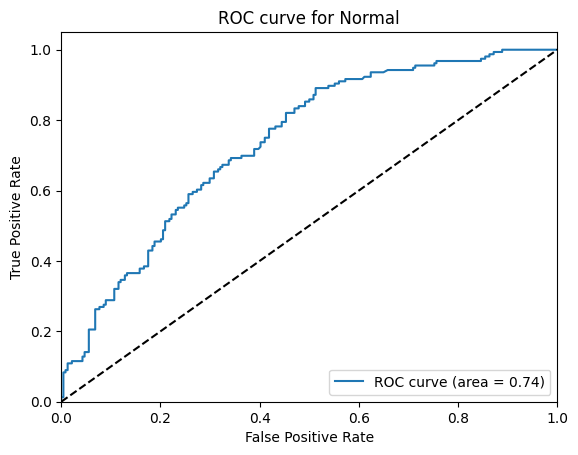

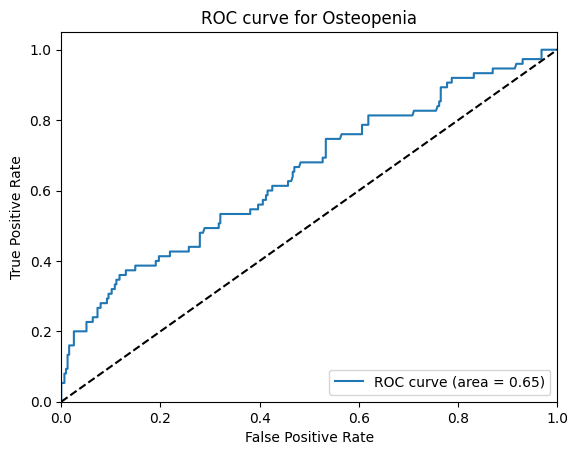

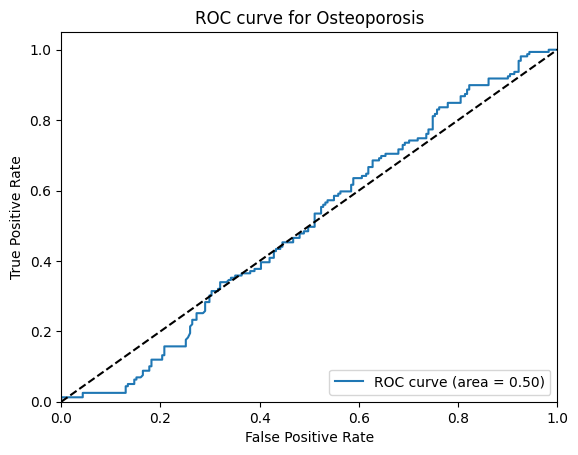

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
y_test = np.array(y_test)
n_classes = 3

pred_Y = model.predict(x_test, batch_size=16, verbose=True)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {labels[i]}')
    plt.legend(loc="lower right")
    plt.show()

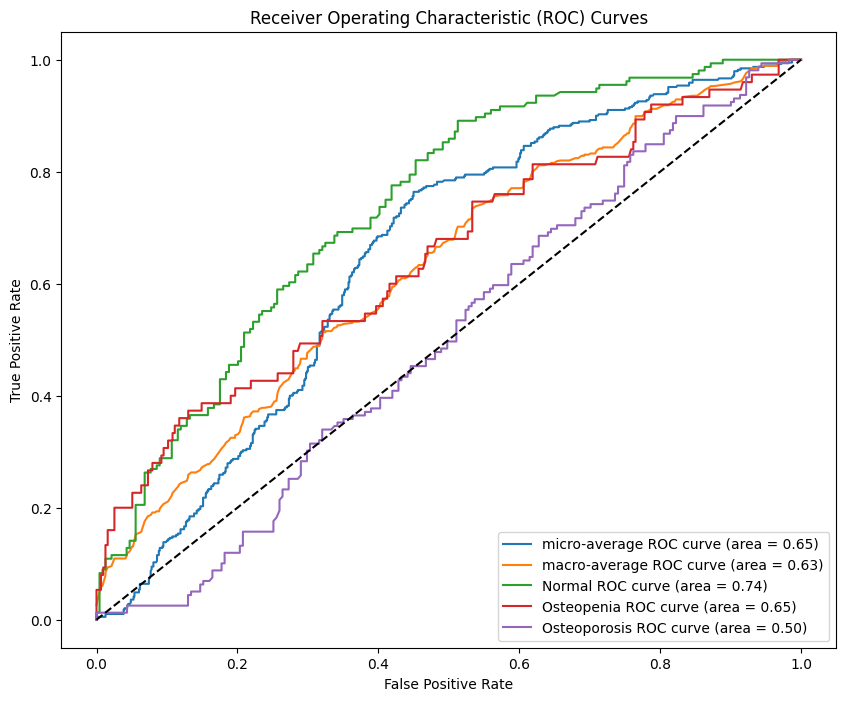

In [ ]:
# Plot all ROC Curves
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = %0.2f)' % roc_auc["macro"])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()